In [48]:
## Package Dependenecies ##
from warnings import filterwarnings,resetwarnings
filterwarnings('ignore', category = RuntimeWarning)
filterwarnings('ignore', category = UserWarning)
filterwarnings('ignore', category = DeprecationWarning)
import pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
import time,os,sys,random,argparse,itertools,csv
from time import strftime
from collections import OrderedDict
from scipy.spatial.distance import cdist,pdist,squareform
from scipy.stats.mstats import zscore
from scipy.stats import norm,percentileofscore
from math import factorial
from seaborn import violinplot
## Configuration and Initialization ##
np.nanmean([])
resetwarnings()
%matplotlib inline

In [49]:
def perm(y,N):
    """ Support function for Kest simulations """
    for i in range(N):
        yield np.random.permutation(y)

In [50]:
def Kest(D,y,T=[],P=9999):
    """ Ripley's K-Function Estimator for Spatial Cluster Analysis (w/ Positional Constraints) (w/o Edge Correction)
            D: Distance matrix for all possible point pairs (observed and unobserved)
            y: Weight vector for all possible points (un-observed points must have NaN weight)
            T: Distance thresholds
            P: Number of permutations for simulated confidence envelope
            Caveat: Current implementation only handles positive weights"""
    assert(P!=1)
    y = np.array(y,dtype=np.float64)
    y[y==0]         = np.nan
    y[~np.isnan(y)] = 1.
    if np.sum(y) == y.size:
        Do = D
        yo = y
    else:
        Do  = D[~np.isnan(y),:][:,~np.isnan(y)] # Distance of observed points
        yo  = y[~np.isnan(y)]  # Values of observed points
    R   = y.size           # Number of protein residues
    N   = yo.size          # Number of observed points
    K = np.array([(Do<t).sum() for t in T],dtype=np.float64) / (N*(N-1))
    if P:
        # Shuffle positions for all points
        K_perm = np.array([Kest(D,yp,T,P=None) for yp in perm(y,P)])
        # Add the observed K vector to the permutation matrix
        K_perm = np.concatenate((K_perm,[K]))
        # Calculate the simulated z-score 
        K_z = zscore(K_perm)[-1]
        # Calculate one-sided permutation p-value given K directionality
        K_p = np.array([1.-percentileofscore(K_perm,K,'strict')/100.,
                                        1.-percentileofscore(-K_perm,-K,'strict')/100.]).T
        p = []
        for i,z in enumerate(K_z):
            if z>0:
                p.append(1.-percentileofscore(K_perm[:,i],K[i],'strict')/100.)
            else:
                p.append(1.-percentileofscore(-K_perm[:,i],-K[i],'strict')/100.)
        K_p = p
        K_pz = norm.sf(abs(K_z))*2 # two-sided simulated p-value
        # Calculate the confidence envelope
        hce  = np.percentile(K_perm,99.5,axis=0)
        lce = np.percentile(K_perm,0.5, axis=0)
        return K,K_p,K_z,K_pz,hce,lce,K_perm
    else:
        return K
Kest.DT = []

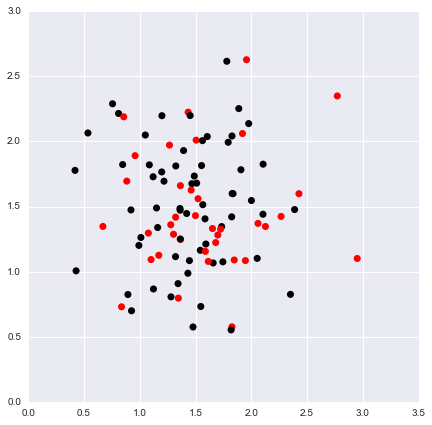

In [51]:
# Generate test distribution of "amino acids"
aa = np.array([np.random.normal(0,0.5,size=100)+1.5,np.random.normal(0,0.5,size=100)+1.5]).T
df = pd.DataFrame(aa,columns=["x","y"])
df["variant"] = 0.
df["color"]   = "black"
v  = np.random.choice(range(len(aa)),50)
df.ix[v,"variant"] = 1.
df.ix[v,"color"]   = "red"

plt.figure(figsize=(7,7))
plt.scatter(df["x"],df["y"],color=df["color"],lw=0,marker='.',s=200)
plt.show()

In [52]:
D = squareform(pdist(df[["x","y"]]))
T = np.arange(1,2,0.01)

In [53]:
# Univariate K with restricted location shuffling
y = df["variant"].values
K11,K11_p,K11_z,K11_pz,hce11,lce11,K11_perm = Kest(D,y,T)

In [54]:
# Multivariate K with random label shuffling (variant,not-variant)
y = np.abs(df.ix[df["variant"]==0,["variant"]].values-1.)
D = squareform(pdist(df.ix[df["variant"]==0,["x","y"]]))
K22,K22_p,K22_z,K22_z,hce22,lce22,K22_perm = Kest(D,y,T=T)

In [55]:
def k_plot(T,K,Kz,lce,hce,ax=None,w=False):
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(20,7))
    c = "darkred" if w else "mediumblue"
    ax.scatter(T,K,s=25,color=c,label=["Un-Weighted","Weighted"][w])
    ax.fill_between(T,lce,hce,alpha=0.1,edgecolor=c,facecolor=c,interpolate=True,antialiased=True)
    ax.set_xlabel("Distance Threshold (t)",fontsize=25)
    ax.set_ylabel("K",fontsize=25)
    ax.set_xlim([min(T),max(T)])
    # Add a vertical line a the most extreme threshold
    dK = np.nanmax(np.abs(Kz),axis=0) # studentized maximum K
    t  = np.nanargmax(np.abs(Kz),axis=0) # t where studentized K is maximized
    # dK = np.nanmax([K-hce,lce-K],axis=0) # directional K-99%
    # t  = np.nanargmax(dK) # t where K is most outside the 99% interval
    T,K = T[t],K[t]
    ax.axvline(T,color=c,lw=2,ls="dashed",label="t=%4.1f,K=%.2f"%(T,K))
    return ax

In [56]:
def ksubk_plot(T,K1,K2,K1_perm,K2_perm,ax=None):
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(20,7))
    ax.scatter(T,K1-K2,s=25,color="darkred")
    lce = np.percentile(K1_perm-K2_perm,99.5,axis=0)
    hce = np.percentile(K1_perm-K2_perm,0.05,axis=0)
    Kz = zscore(K11_perm-K22_perm)[-1]
    ax.fill_between(T,lce,hce,alpha=0.1,edgecolor="darkred",facecolor="darkred",interpolate=True,antialiased=True)
    ax.set_xlabel("Distance Threshold (t)",fontsize=25)
    ax.set_ylabel("K1-K2",fontsize=25)
    ax.set_xlim([min(T),max(T)])
    # Add a vertical line a the most extreme threshold
    dK = np.nanmax(np.abs(Kz),axis=0) # studentized maximum K
    t  = np.nanargmax(np.abs(Kz),axis=0) # t where studentized K is maximized
    # dK = np.nanmax([K-hce,lce-K],axis=0) # directional K-99%
    # t  = np.nanargmax(dK) # t where K is most outside the 99% interval
    T,K = T[t],(K11-K22)[t]
    ax.axvline(T,color="darkred",lw=2,ls="dashed",label="t=%4.1f,K=%.2f"%(T,K))
    return ax

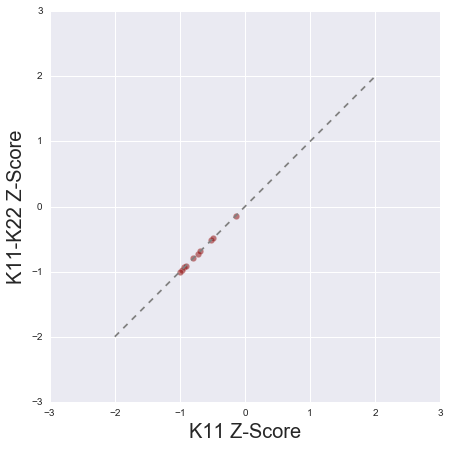

In [57]:
KsubK_z = zscore(K11_perm-K22_perm)[-1]
plt.figure(figsize=(7,7))
plt.scatter(K11_z,KsubK_z,s=40,c="darkred",alpha=0.5)
plt.plot([-2,2],[-2,2],ls='dashed',c='grey')
plt.xlabel("K11 Z-Score",fontsize=20)
plt.ylabel("K11-K22 Z-Score",fontsize=20)
plt.show()

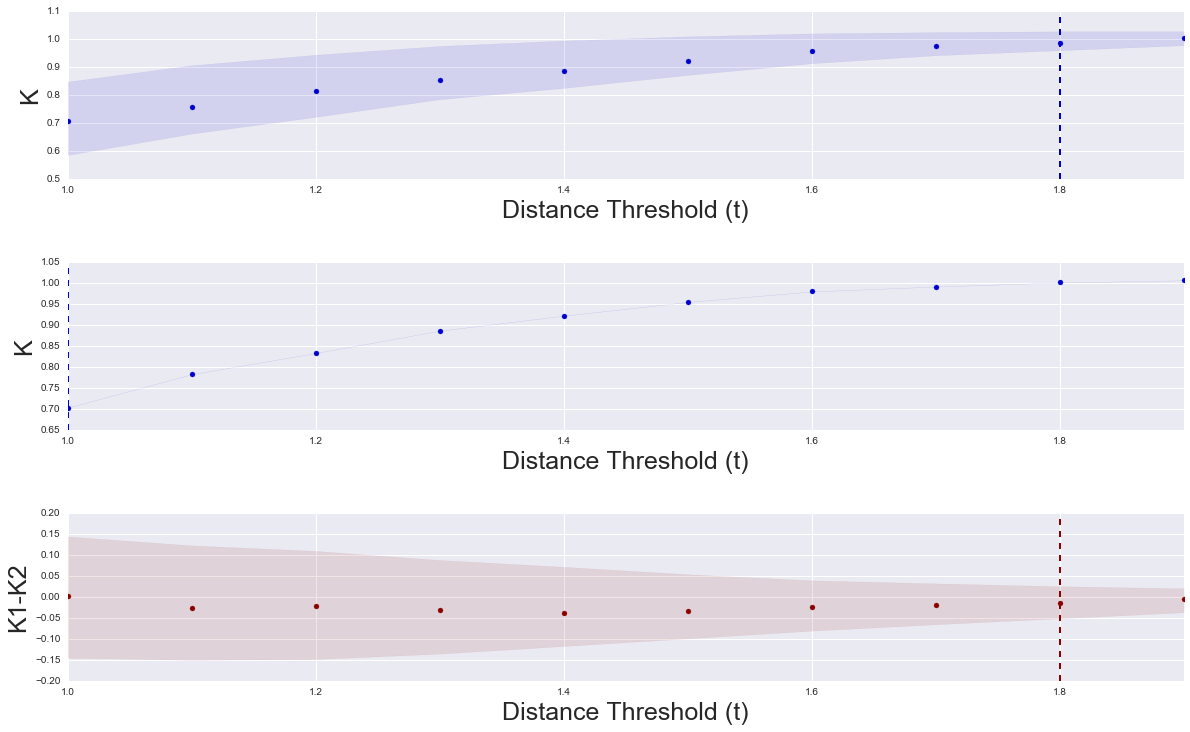

In [58]:
fig,ax = plt.subplots(3,1,figsize=(20,12))
k_plot(T,K11,K11_z,lce11,hce11,ax[0])
k_plot(T,K22,K22_z,lce22,hce22,ax[1])
ksubk_plot(T,K11,K22,K11_perm,K22_perm,ax[2])
plt.show()

Calculate K12* for two random sets
Run a toroidal shift permutation test
Run a random label assignment permutation test
Compare the z-scores from the two permutation tests to see if they're correlated
If they are correlated, then this is a moot point, we use random label assignment and everyone's happy

In [60]:
## Randomly shuffles labels between classes 1 and 2
def Pshuffle(y1,y2,P):
    N1 = y1.shape[0]
    y = np.concatenate((y1,y2),axis=0)
    for i in range(P):
        y = np.random.permutation(y)
        yield (y[:N1+1,:],y[N1:,:])

In [111]:
## Toroidal shift of y1
def Pshift(y1,A,P):
    N1 = y1.size
    for i in range(P):
        y1[:,0] = (y1[:,0] + np.random.uniform(*A,size=1)) % max(A)
        y1[:,1] = (y1[:,1] + np.random.uniform(*A,size=1)) % max(A)
#         plt.figure(figsize=(7,7))
#         plt.scatter(y1[:,0],y1[:,1],color="red",lw=0,marker='.',s=200)
#         plt.scatter(y2[:,0],y2[:,1],color="black",lw=0,marker='.',s=200)
#         plt.xlim([0,3])
#         plt.ylim([0,3])
#         plt.show()
        yield y1

In [112]:
from itertools import product
def tdist(y1,y2,A):
    return np.array([[np.sqrt(min(np.abs(y11[0] - y22[0]), max(A) - np.abs(y11[0] - y22[0]))**2 + min(np.abs(y11[1] - y22[1]), max(A) - np.abs(y11[1]-y22[1]))**2) for y22 in y2] for y11 in y1])

In [138]:
def Kstar(y1,y2,T=[],P=9,pfunc=''):
    assert(P!=1)
    N  = y1.size * y2.size
    ## Calculate bipartite distance matrix
#     Dstar = cdist(y1,y2)
    Dstar = tdist(y1,y2,(0,2))
    K  = np.array([(Dstar<t).sum() for t in T],dtype=np.float64) / N
    if P:
        if pfunc == "shuffle":
            K_perm = np.array([Kstar(y1p,y2p,T,P=None) for y1p,y2p in Pshuffle(y1,y2,P=P)])
        elif pfunc == "shift":
            K_perm = np.array([Kstar(y1p,y2,T,P=None) for y1p in Pshift(y1,A=(0,2),P=P)])
        K_perm = np.concatenate((K_perm,[K]))
        K_z    = zscore(K_perm)[-1]
        K_p    = np.array([1.-percentileofscore(K_perm,K,'strict')/100.,
                           1.-percentileofscore(-K_perm,-K,'strict')/100.]).T
        p = []
        for i,z in enumerate(K_z):
            if z>0:
                p.append(1.-percentileofscore(K_perm[:,i],K[i],'strict')/100.)
            else:
                p.append(1.-percentileofscore(-K_perm[:,i],-K[i],'strict')/100.)
        K_p  = p
        K_pz = norm.sf(abs(K_z))*2 # two-sided simulated p-value
        # Calculate the confidence envelope
        hce  = np.percentile(K_perm,99.5,axis=0)
        lce = np.percentile(K_perm,0.5, axis=0)
        return K,K_p,K_z,K_pz,hce,lce,K_perm
    else:
        return K

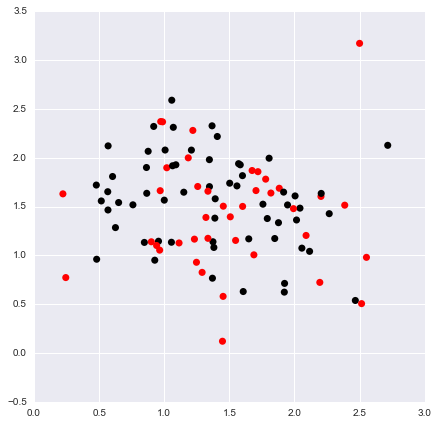

In [139]:
# Generate test distribution of "amino acids"
aa = np.array([np.random.normal(0,0.5,size=100)+1.5,np.random.normal(0,0.5,size=100)+1.5]).T
df = pd.DataFrame(aa,columns=["x","y"])
df["variant"] = 0.
df["color"]   = "black"
v  = np.random.choice(range(len(aa)),50)
df.ix[v,"variant"] = 1.
df.ix[v,"color"]   = "red"

plt.figure(figsize=(7,7))
plt.scatter(df["x"],df["y"],color=df["color"],lw=0,marker='.',s=200)
plt.show()

In [140]:
y1 = df.ix[df["variant"]==1,["x","y"]].values
y2 = df.ix[df["variant"]==0,["x","y"]].values
T = np.arange(1,2,0.02)
Kh,Kh_p,Kh_z,Kh_pz,hceh,lceh,Kh_perm = Kstar(y1,y2,T,P=999,pfunc='shuffle')
Ks,Ks_p,Ks_z,Ks_pz,hces,lces,Ks_perm = Kstar(y1,y2,T,P=999,pfunc='shift')

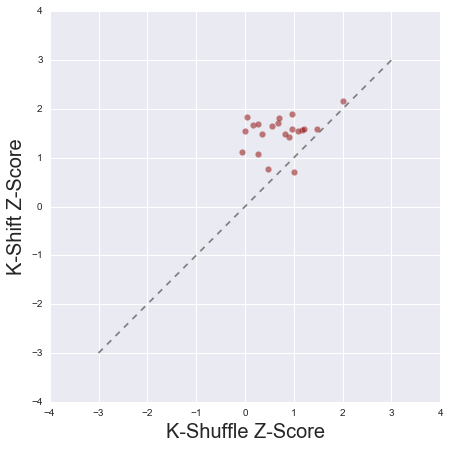

In [141]:
plt.figure(figsize=(7,7))
plt.scatter(Kh_z,Ks_z,s=40,c="darkred",alpha=0.5)
plt.plot([-3,3],[-3,3],ls='dashed',c='grey')
plt.xlabel("K-Shuffle Z-Score",fontsize=20)
plt.ylabel("K-Shift Z-Score",fontsize=20)
plt.show()

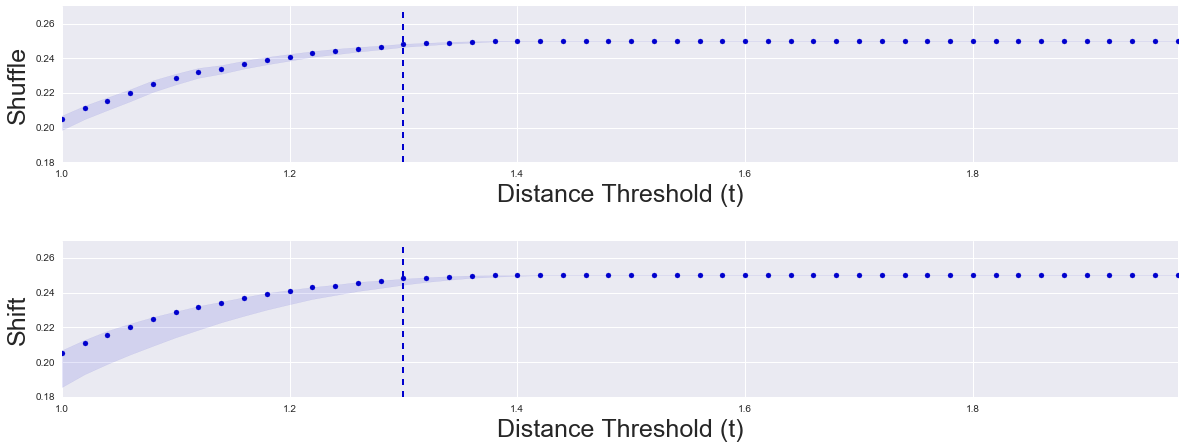

In [142]:
# Plot of Kstar with
fig,ax = plt.subplots(2,1,figsize=(20,7),sharey=True)
ax[0] = k_plot(T,Kh,Kh_z,lceh,hceh,ax[0])
ax[0].set_ylabel("Shuffle")
ax[1] = k_plot(T,Ks,Ks_z,lces,hces,ax[1])
ax[1].set_ylabel("Shift")
plt.show()

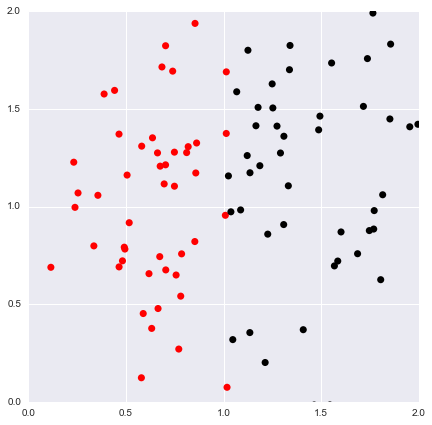

In [143]:
# Simulate a separation between the two classes
# Generate test distribution of "amino acids"
aa = np.array([np.random.normal(0,0.5,size=100)+1.,np.random.normal(0,0.5,size=100)+1.]).T
df = pd.DataFrame(aa,columns=["x","y"])
df["variant"] = 0
df["color"]   = "black"
df = df.sort_values(by="x").reset_index()
v  = df.index[:50]
df.ix[v,"variant"] = 1
df.ix[v,"color"]   = "red"

plt.figure(figsize=(7,7))
plt.scatter(df["x"],df["y"],color=df["color"],lw=0,marker='.',s=200)
plt.xlim([0,2.])
plt.ylim([0,2.])
plt.show()

In [144]:
y1 = df.ix[df["variant"]==1,["x","y"]].values
y2 = df.ix[df["variant"]==0,["x","y"]].values
T = np.arange(1,2,0.02)
Kh,Kh_p,Kh_z,Kh_pz,hceh,lceh,Kh_perm = Kstar(y1,y2,T,P=9999,pfunc='shuffle')
Ks,Ks_p,Ks_z,Ks_pz,hces,lces,Ks_perm = Kstar(y1,y2,T,P=9999,pfunc='shift')

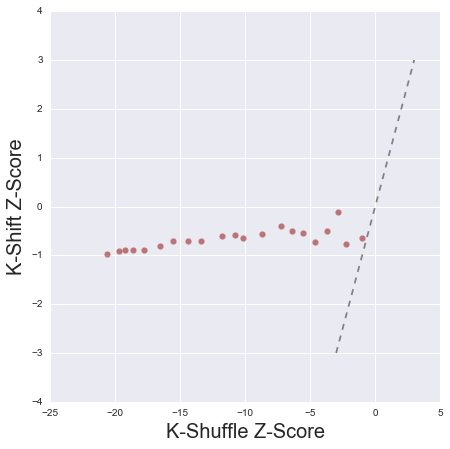

In [145]:
plt.figure(figsize=(7,7))
plt.scatter(Kh_z,Ks_z,s=40,c="darkred",alpha=0.5)
plt.plot([-3,3],[-3,3],ls='dashed',c='grey')
plt.xlabel("K-Shuffle Z-Score",fontsize=20)
plt.ylabel("K-Shift Z-Score",fontsize=20)
plt.show()

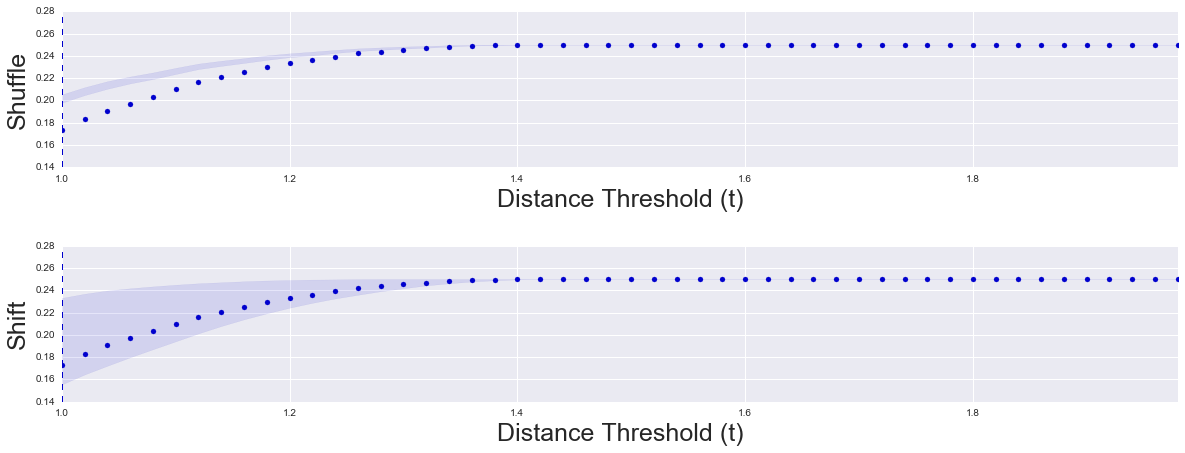

In [146]:
fig,ax = plt.subplots(2,1,figsize=(20,7),sharey=True)
ax[0] = k_plot(T,Kh,Kh_z,lceh,hceh,ax[0])
ax[0].set_ylabel("Shuffle")
ax[1] = k_plot(T,Ks,Ks_z,lces,hces,ax[1])
ax[1].set_ylabel("Shift")
plt.show()